In [ ]:
# %load_ext lab_black

# make clean

In [1]:
import os
import pandas as pd

In [2]:
def clean_dataset(target_path, save_path):
    
    for _ in os.listdir(target_path):

        data = pd.read_csv(
            os.path.join(target_path, _),
            encoding="unicode_escape",
            sep=";",
            header=None,
        )

        time = []
        sens1 = []
        sens2 = []

        for index, row in data.iloc[7:].iterrows():

            row = row[0].split(",")

            time.append(float(row[0]))
            sens1.append(float(row[1]))
            sens2.append(float(row[2]))

        data_frame = {"time": time, "sensor_1": sens1, "sensor_2": sens2}

        data_frame = pd.DataFrame(data_frame)

        data_frame.to_csv(os.path.join(save_path, _))


path = "../../vibration_noise_detection/datasets/vibration_data"
target_pathes = ["OK", "NG"]
save_pathes = ["OK_clean", "NG_clean"]

for target_path, save_path in zip(target_pathes, save_pathes):
    clean_dataset(os.path.join(path, target_path), os.path.join(path, save_path))

# prepare signal and extract features

In [1]:
import os
import numpy as np
import pandas as pd

import pywt
import scipy.signal as ss
import scipy.stats as sp
import matplotlib.pyplot as plt

In [2]:
def read_data(path):

    data = pd.read_csv(path)

    return (
        np.array(data["time"]),
        np.array(data["sensor_1"]),
        np.array(data["sensor_2"]),
    )


def remove_DC(signal, order, cutoff, fs):
    sos = ss.butter(order, cutoff, 'hp', fs=fs, output='sos')
    return ss.sosfilt(sos, signal)

        
def psd(signal, fs, nperseg=1024):
    f, Pxx_den = ss.welch(signal, fs, nperseg=nperseg)
    return np.log(Pxx_den)


def static_features(signal):

    def minimum(c):
        return np.min(c, axis=1)
    
    
    def maximum(c):
        return np.max(c, axis=1)
    
    
    def mean(c):
        return np.mean(c, axis=1)
    
    
    def std(c):
        return np.std(c, axis=1)
    
    
    def coeff_var(c):
        return np.log(sp.variation(c, axis=1))


    def kurtosis(c):
        return np.log(sp.kurtosis(c, axis=1))
    
    
    def wavelet_packet_energy(signal):
        return np.log(np.sqrt(np.sum(np.power(signal, 2) / signal.shape[1], axis=1)))
    
    feats = [minimum, maximum, mean, std, kurtosis, wavelet_packet_energy] # coeff_var
    
    return np.array([feat(signal) for feat in feats]).T


def main(path):
    
    time, sensor_1, sensor_2 = read_data(path)
    data = {"time":time, "sensor_1":{"signal":sensor_1}, "sensor_2":{"signal":sensor_2}}
    
    data["sensor_1"]["filtered"] = remove_DC(data["sensor_1"]["signal"], 20, 2, 1000)
    data["sensor_2"]["filtered"] = remove_DC(data["sensor_2"]["signal"], 20, 2, 1000)


    data["sensor_1"]["psd"] = psd(signal=np.array([data["sensor_1"]["filtered"]]), fs=1000)
    data["sensor_2"]["psd"] = psd(signal=np.array([data["sensor_2"]["filtered"]]), fs=1000)


    data["sensor_1"]["static_features"] = static_features(signal=np.array([data["sensor_1"]["filtered"]])) # mean max std kurtosis
    data["sensor_2"]["static_features"] = static_features(signal=np.array([data["sensor_2"]["filtered"]]))
    
    return data


In [69]:
path = "../../vibration_noise_detection/datasets/vibration_data/OK_clean/DAS64100_OK_2_1st.CSV"
OK_engine = main(path)

path = "../../vibration_noise_detection/datasets/vibration_data/NG_clean/DAS56284_NG_3_2nd.CSV"
NG_engine = main(path)

In [70]:
OK_engine["sensor_1"]["signal"].shape

(436839,)

In [ ]:
436837

## main signal

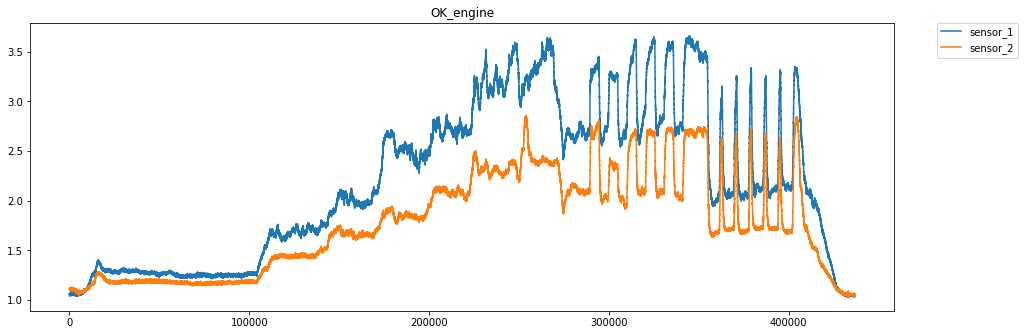

In [245]:
fig = plt.figure()
ax = fig.add_axes([1, 0.5, 2, 1])

ax.plot(OK_engine["sensor_1"]["signal"], label="sensor_1")
ax.plot(OK_engine["sensor_2"]["signal"], label="sensor_2")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title('OK_engine')
plt.show()

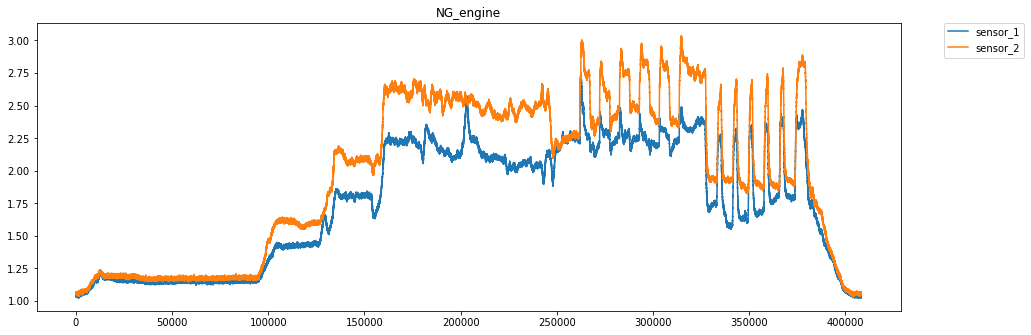

In [246]:
fig = plt.figure()
ax = fig.add_axes([1, 0.5, 2, 1])

ax.plot(NG_engine["sensor_1"]["signal"], label="sensor_1")
ax.plot(NG_engine["sensor_2"]["signal"], label="sensor_2")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title('NG_engine')
plt.show()

## filtered signal

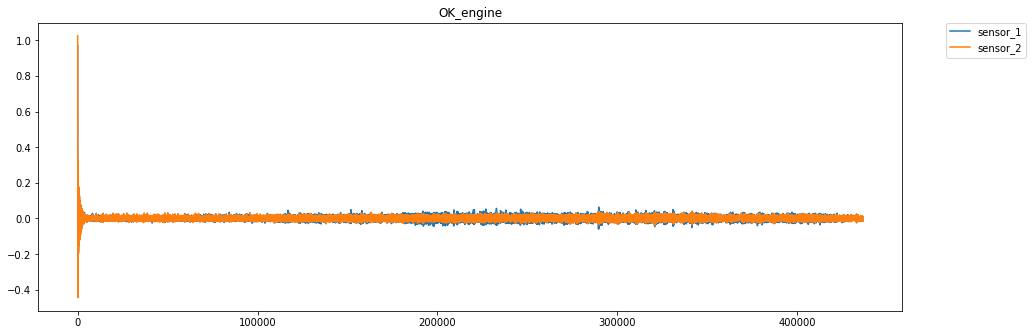

In [247]:
fig = plt.figure()
ax = fig.add_axes([1, 0.5, 2, 1])

ax.plot(OK_engine["sensor_1"]["filtered"], label="sensor_1")
ax.plot(OK_engine["sensor_2"]["filtered"], label="sensor_2")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title('OK_engine')
plt.show()

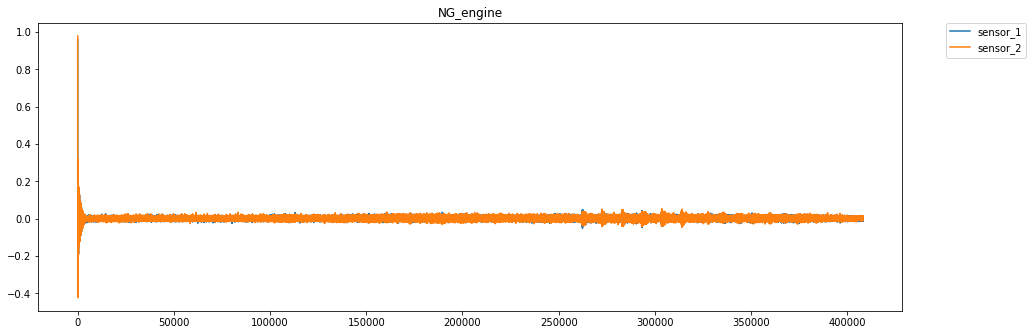

In [248]:
fig = plt.figure()
ax = fig.add_axes([1, 0.5, 2, 1])

ax.plot(NG_engine["sensor_1"]["filtered"], label="sensor_1")
ax.plot(NG_engine["sensor_2"]["filtered"], label="sensor_2")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title('NG_engine')
plt.show()

## psd

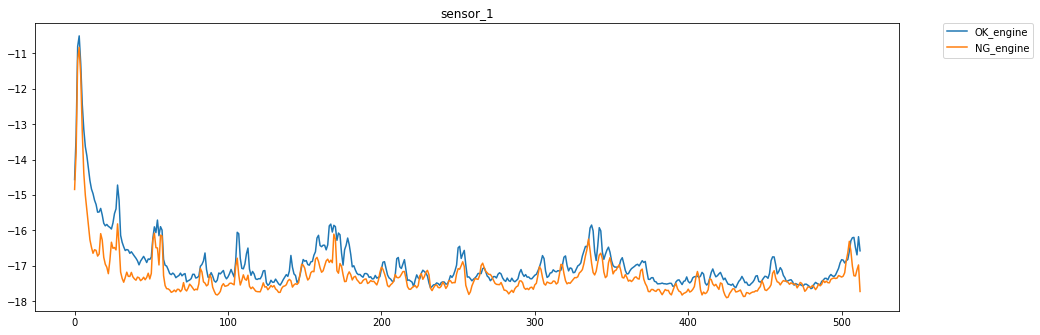

In [249]:
fig = plt.figure()
ax = fig.add_axes([1, 0.5, 2, 1])

ax.plot(OK_engine["sensor_1"]["psd"][0], label="OK_engine")
ax.plot(NG_engine["sensor_1"]["psd"][0], label="NG_engine")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title('sensor_1')
plt.show()

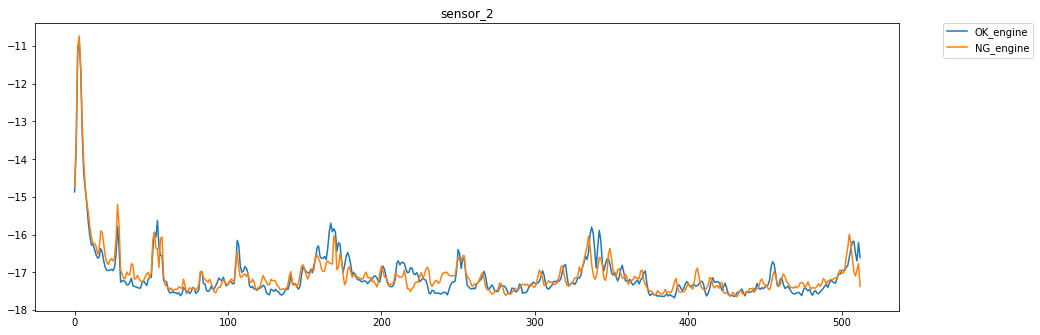

In [250]:
fig = plt.figure()
ax = fig.add_axes([1, 0.5, 2, 1])

ax.plot(OK_engine["sensor_2"]["psd"][0], label="OK_engine")
ax.plot(NG_engine["sensor_2"]["psd"][0], label="NG_engine")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title('sensor_2')
plt.show()

## static_features

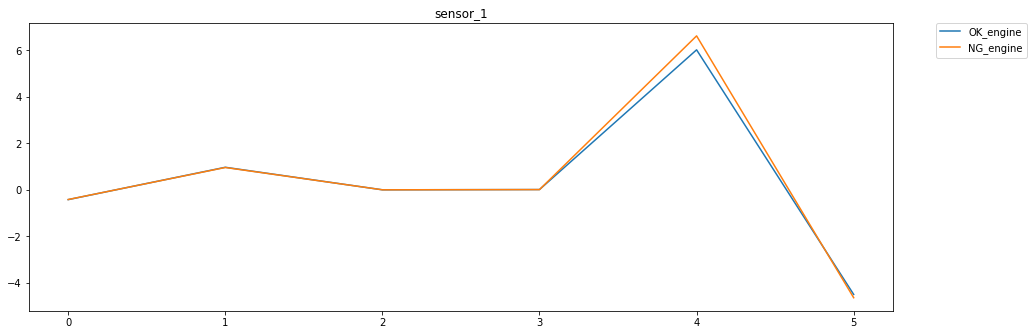

In [251]:
fig = plt.figure()
ax = fig.add_axes([1, 0.5, 2, 1])

ax.plot(OK_engine["sensor_1"]["static_features"][0], label="OK_engine")
ax.plot(NG_engine["sensor_1"]["static_features"][0], label="NG_engine")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title('sensor_1')
plt.show()

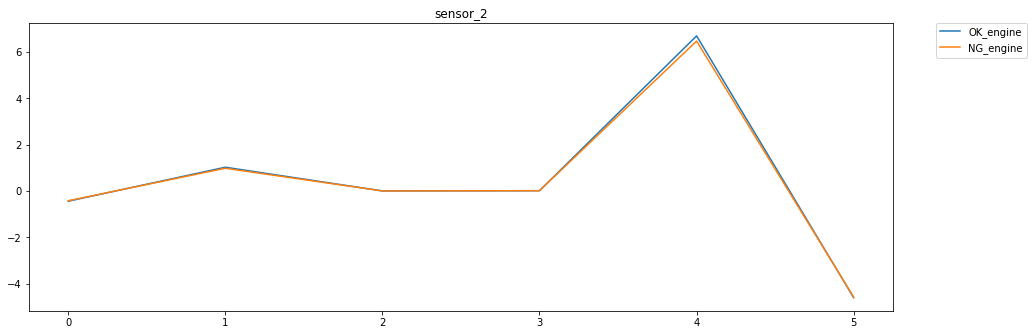

In [252]:
fig = plt.figure()
ax = fig.add_axes([1, 0.5, 2, 1])

ax.plot(OK_engine["sensor_2"]["static_features"][0], label="OK_engine")
ax.plot(NG_engine["sensor_2"]["static_features"][0], label="NG_engine")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title('sensor_2')
plt.show()

# test

## dataset

In [3]:
import numpy as np

from typing import (
    Tuple,
    List,
)


class ToNumpy(object):
    def __call__(self, data):
        data["signals"] = np.array(data["signals"])
        data["labels"] = np.array(data["labels"])
        return data

    def __repr__(self):
        return self.__class__.__name__ + "()"


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data):
        for t in self.transforms:
            data = t(data)
        return data


In [8]:
import os
import numpy as np
import pandas as pd
import scipy.signal as ss

from typing import (
    Tuple,
    List,
    Dict,
)


class VibrationNoiseDataset(object):
    """ """

    def __init__(
        self,
        data_path: str,
        time_points: List, 
        cutoff: int = 1,
        transforms=None,
    ) -> None:

        self.data_path = data_path
        self.time_points = time_points
        self.cutoff = cutoff
        self.transforms = transforms
            
        self.meta_data = {}
        for root, dirs, files in os.walk(data_path):
            for file in files:
                if os.path.split(root)[-1] not in self.meta_data.keys():
                    self.meta_data[os.path.split(root)[-1]] = []
                self.meta_data[os.path.split(root)[-1]].append(os.path.join(root, file))

    def get_engine_names(self) -> np.array:
        return '\n\t\t\t'.join(list(np.reshape(list(self.meta_data.values()), (-1,))))

    def get_sampling_rate(self) -> int:
        return 1000

    def chunk_signal(
        self, 
        signal: np.array,
        label: int,
        engine_name: str,
        sensor_number: int,
        time_points: List,
        data: Dict = None,
    ) -> Tuple[List, List]:

        if data==None:
            data = {"engine_names":[], "sensor_number":[], "labels":[], "part_numbers":[], "signals":[]}

        for idx ,time_point in enumerate(zip(time_points[:-1], time_points[1:])):

            data["engine_names"].append(engine_name)
            data["sensor_number"].append(sensor_number)
            data["labels"].append(label)
            data["part_numbers"].append(idx)
            data["signals"].append(signal[time_point[0]:time_point[1]])

        return data

    def remove_DC(self, signal: np.array, cutoff: int, order: int = 20) -> np.array:        
        sos = ss.butter(
            order, cutoff, "hp", fs=self.get_sampling_rate(), output="sos"
        )
        return ss.sosfilt(sos, signal)

    def __len__(self) -> int:
        return len(list(np.reshape(list(self.meta_data.values()), (-1,))))

    def __getitem__(self):

        data = None

        for _ in self.meta_data.keys():

            for csv_data_path in self.meta_data[_]:

                engine_data = pd.read_csv(csv_data_path)
                engine_data["sensor_1"] = self.remove_DC(
                    np.array(engine_data["sensor_1"]), self.cutoff
                )
                engine_data["sensor_2"] = self.remove_DC(
                    np.array(engine_data["sensor_2"]), self.cutoff
                )
                
                data = self.chunk_signal(
                    signal = np.array(engine_data["sensor_1"]),
                    label = 0 if _ == "OK_clean" else 1,
                    engine_name = os.path.split(csv_data_path)[-1],
                    sensor_number = 1,
                    time_points = self.time_points,
                    data = data
                )
                
                data = self.chunk_signal(
                    signal = np.array(engine_data["sensor_2"]),
                    label = 0 if _ == "OK_clean" else 1,
                    engine_name = os.path.split(csv_data_path)[-1],
                    sensor_number = 2,
                    time_points = self.time_points,
                    data = data
                )


        if self.transforms is not None:
            data = self.transforms(data)

        return data

    def __repr__(self) -> str:
        return (
            "#############################################################\n"
            + f"Dataset              : {self.__class__.__name__}\n"
            + f"# Engine Names       : {self.get_engine_names()}\n"
            + f"# Sampling Rate      : {self.get_sampling_rate()}\n"
            + "#############################################################\n"
        )


In [9]:
data_path = "../../vibration_noise_detection/datasets/vibration_data"
time_points = [0,131710, 214029, 274396, 321592, 360007, 398422, -1] # compute by using numbers
cutoff = 10
transforms = Compose([ToNumpy()])
        
cc = VibrationNoiseDataset(data_path, time_points, cutoff, transforms)

In [10]:
data = cc.__getitem__()

/tmp/ipykernel_24400/775707964.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data["signals"] = np.array(data["signals"])


In [257]:
# x = data["signals"][np.array(data["part_numbers"]) == 3]
# x = np.stack(x, axis=0).squeeze()

## psd

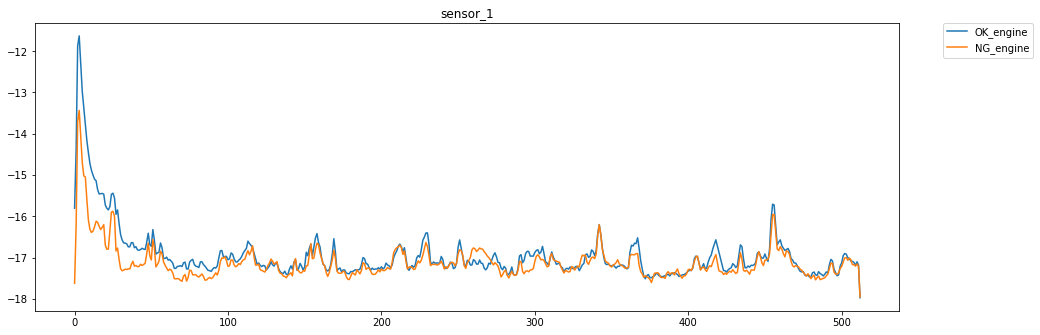

In [118]:
import matplotlib.pyplot as plt

data_path = "../../vibration_noise_detection/datasets/vibration_data"
time_points = [0,131710, 214029, 274396, 321592, 360007, 398422, -1] # compute by using numbers
cutoff = 2
transforms = Compose([ToNumpy()])

cc = VibrationNoiseDataset(data_path, time_points, cutoff, transforms)
data = cc.__getitem__()

part_number = 1
sensor_number = 1

idxes = np.multiply(
    np.array(data["part_numbers"]) == part_number,
    np.array(data["sensor_number"]) == sensor_number,
)

fig = plt.figure()
ax = fig.add_axes([1, 0.5, 2, 1])

x = np.stack(
    data["signals"][np.multiply(np.array(data["labels"]) == 0, idxes)], axis=0
).squeeze()
psd_signal = psd(signal=x, fs=1000)
ax.plot(np.mean(psd_signal, axis=0), label="OK_engine")

x = np.stack(
    data["signals"][np.multiply(np.array(data["labels"]) == 1, idxes)], axis=0
).squeeze()
psd_signal = psd(signal=x, fs=1000)
ax.plot(np.mean(psd_signal, axis=0), label="NG_engine")

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

plt.title(f"sensor_{sensor_number}")
plt.show()

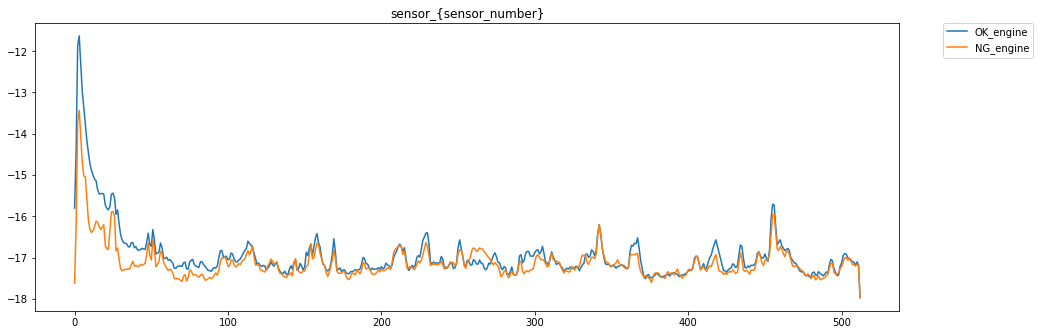

In [75]:
data_path = "../../vibration_noise_detection/datasets/vibration_data"
time_points = [0,131710, 214029, 274396, 321592, 360007, 398422, -1] # compute by using numbers
cutoff = 2
transforms = Compose([ToNumpy()])

cc = VibrationNoiseDataset(data_path, time_points, cutoff, transforms)
data = cc.__getitem__()

part_number = 1
sensor_number = 1

idxes = np.multiply(
    np.array(data["part_numbers"]) == part_number,
    np.array(data["sensor_number"]) == sensor_number,
)

fig = plt.figure()
ax = fig.add_axes([1, 0.5, 2, 1])

x = np.stack(
    data["signals"][np.multiply(np.array(data["labels"]) == 0, idxes)], axis=0
).squeeze()
psd_signal = psd(signal=x, fs=1000)
ax.plot(np.mean(psd_signal, axis=0), label="OK_engine")

x = np.stack(
    data["signals"][np.multiply(np.array(data["labels"]) == 1, idxes)], axis=0
).squeeze()
psd_signal = psd(signal=x, fs=1000)
ax.plot(np.mean(psd_signal, axis=0), label="NG_engine")

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

plt.title("sensor_{sensor_number}")
plt.show()

## static_features

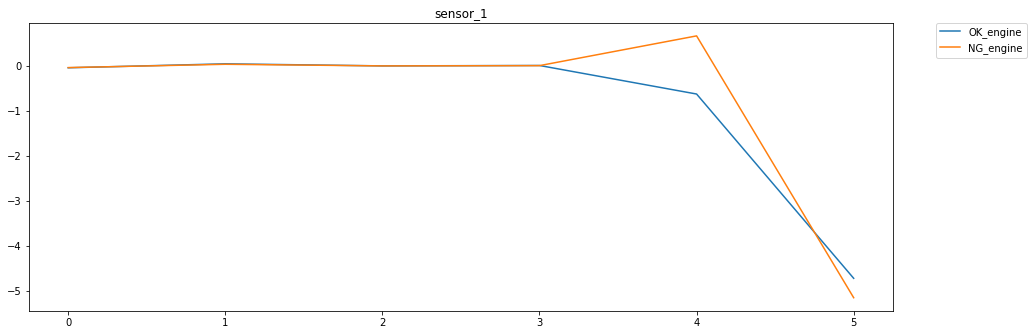

In [76]:
data_path = "../../vibration_noise_detection/datasets/vibration_data"
time_points = [0,131710, 214029, 274396, 321592, 360007, 398422, -1] # compute by using numbers
cutoff = 2
transforms = Compose([ToNumpy()])

cc = VibrationNoiseDataset(data_path, time_points, cutoff, transforms)
data = cc.__getitem__()

part_number = 2
sensor_number = 1

idxes = np.multiply(
    np.array(data["part_numbers"]) == part_number,
    np.array(data["sensor_number"]) == sensor_number,
)

fig = plt.figure()
ax = fig.add_axes([1, 0.5, 2, 1])

x = np.stack(
    data["signals"][np.multiply(np.array(data["labels"]) == 0, idxes)], axis=0
).squeeze()
static_features_signal = static_features(signal=x)
ax.plot(np.mean(static_features_signal, axis=0), label="OK_engine")

x = np.stack(
    data["signals"][np.multiply(np.array(data["labels"]) == 1, idxes)], axis=0
).squeeze()
static_features_signal = static_features(signal=x)

ax.plot(np.mean(static_features_signal, axis=0), label="NG_engine")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

plt.title(f"sensor_{sensor_number}")
plt.show()

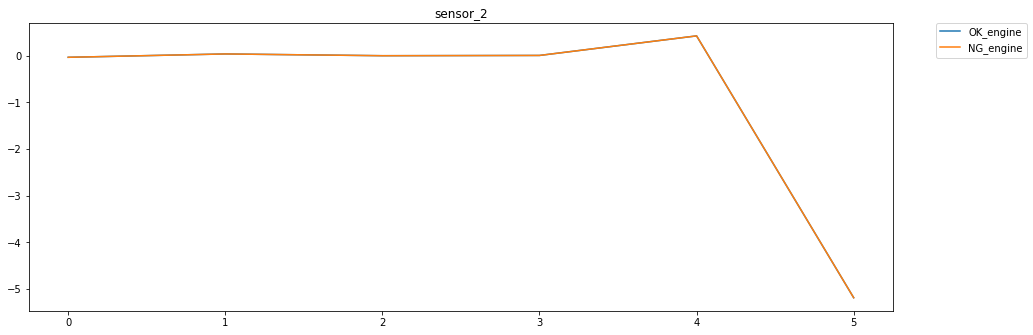

In [77]:
data_path = "../../vibration_noise_detection/datasets/vibration_data"
time_points = [0,131710, 214029, 274396, 321592, 360007, 398422, -1] # compute by using numbers
cutoff = 2
transforms = Compose([ToNumpy()])

cc = VibrationNoiseDataset(data_path, time_points, cutoff, transforms)
data = cc.__getitem__()

part_number = 1
sensor_number = 2

idxes = np.multiply(
    np.array(data["part_numbers"]) == part_number,
    np.array(data["sensor_number"]) == sensor_number,
)

fig = plt.figure()
ax = fig.add_axes([1, 0.5, 2, 1])

x = np.stack(
    data["signals"][np.multiply(np.array(data["labels"]) == 0, idxes)], axis=0
).squeeze()
static_features_signal = static_features(signal=x)
ax.plot(np.mean(static_features_signal, axis=0), label="OK_engine")


static_features_signal = static_features(signal=x)

ax.plot(np.mean(static_features_signal, axis=0), label="NG_engine")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

plt.title(f"sensor_{sensor_number}")
plt.show()

## models

In [78]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


import numpy as np

KNEIGHBORSPARAMGRID = {"n_neighbors": list(range(1, 31))}

KNEIGHBORSMODEL = KNeighborsClassifier()


LOGISTICREGRESSIONPARAMGRID = {
    "penalty": ["l1", "l2"],
    "C": np.logspace(-3, 3, 7),
    "solver": ["newton-cg", "lbfgs", "liblinear"],
}

LOGISTICREGRESSIONMODEL = LogisticRegression()

SVMPARAMGRID = {
    "C": [0.1, 1, 10, 100, 1000],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["linear", "poly", "rbf"],
}

SVMMODEL = svm.SVC()


DECISIONTREEClASSIFIERPARAMGRID = {
    "max_leaf_nodes": list(range(2, 100)),
    "min_samples_split": [2, 3, 4],
}

DECISIONTREEClASSIFIERMODEL = DecisionTreeClassifier()


RANDOMFORESTClASSIFIERPARAMGRID = {
    "n_estimators": [200, 500],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [4, 5, 6, 7, 8],
    "criterion": ["gini", "entropy"],
}

RANDOMFORESTClASSIFIERMODEL = RandomForestClassifier(random_state=42)


XGBClASSIFIERPARAMGRID = {
    "max_depth": range(2, 10, 1),
    "n_estimators": range(60, 220, 40),
    "learning_rate": [0.1, 0.01, 0.05],
}

XGBClASSIFIERMODEL = XGBClassifier(objective="binary:logistic", nthread=4, seed=42)


In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


def select_model(opts):  ## in train.py  if grid_search on use if clf.get_best_estimator
    if opts["grid_search"] == "ON":

        if opts["model"] == "KNeighborsClassifier":
            clf = GridSearchCV(
                estimator=KNEIGHBORSMODEL,
                param_grid=KNEIGHBORSPARAMGRID,
                cv=5,
                verbose=1,
            )

        elif opts["model"] == "LogisticRegression":
            clf = GridSearchCV(
                estimator=LOGISTICREGRESSIONMODEL,
                param_grid=LOGISTICREGRESSIONPARAMGRID,
                cv=5,
                verbose=1,
            )

        elif opts["model"] == "svm":
            clf = GridSearchCV(
                estimator=SVMMODEL, param_grid=SVMPARAMGRID, cv=5, verbose=1
            )

        elif opts["model"] == "DecisionTreeClassifier":
            clf = GridSearchCV(
                estimator=DECISIONTREEClASSIFIERMODEL,
                param_grid=DECISIONTREEClASSIFIERPARAMGRID,
                cv=5,
                verbose=1,
            )

        elif opts["model"] == "RandomForestClassifier":
            clf = GridSearchCV(
                estimator=RANDOMFORESTClASSIFIERMODEL,
                param_grid=RANDOMFORESTClASSIFIERPARAMGRID,
                cv=5,
                verbose=1,
            )

        elif opts["model"] == "XGBClassifier":
            clf = GridSearchCV(
                estimator=XGBClASSIFIERMODEL,
                param_grid=XGBClASSIFIERPARAMGRID,
                cv=5,
                verbose=1,
            )

        else:
            print(f"unknown model type {opts['model']}")
            clf = None

    elif opts["grid_search"] == "OFF":

        if opts["model"] == "KNeighborsClassifier":
            clf = KNEIGHBORSMODEL

        elif opts["model"] == "LogisticRegression":
            clf = LOGISTICREGRESSIONMODEL

        elif opts["model"] == "svm":
            clf = SVMMODEL

        elif opts["model"] == "DecisionTreeClassifier":
            clf = DECISIONTREEClASSIFIERMODEL

        elif opts["model"] == "RandomForestClassifier":
            clf = RANDOMFORESTClASSIFIERMODEL

        elif opts["model"] == "XGBClassifier":
            clf = XGBClASSIFIERMODEL

        else:
            print(f"unknown model type {opts['model']}")
            clf = None

    return clf


def feature_extraction(feature_names, data):

    for feature_name in feature_names:

        if feature_name == "psd":

            features = []
            for _ in data["signals"]:
                features.append(psd(_, fs=1000))

            data[feature_name] = features

        elif feature_name == "static_feature":

            features = []
            for _ in data["signals"]:
                features.append(static_features(np.array([_])))

            data[feature_name] = features

        else:
            print(f"unknown feature_name type {feature_name}")

    return data


def concate_sensor_features(data, feature_name):

    sensor_1 = (
        data.query("`sensor_number` == 1")
        .sort_values(by=["engine_names"])
        .sort_values(by=["part_numbers"])
    )
    sensor_2 = (
        data.query("`sensor_number` == 2")
        .sort_values(by=["engine_names"])
        .sort_values(by=["part_numbers"])
    )
    meta_data = sensor_1[["engine_names", "part_numbers", "labels"]]

    y = np.array(sensor_1["labels"])
        
    sensor_1 = np.stack(sensor_1[feature_name], axis=0).squeeze()
    sensor_2 = np.stack(sensor_2[feature_name], axis=0).squeeze()
    
    x = np.concatenate((sensor_1, sensor_2), axis=1)

    return x, y, meta_data


def fit_eval(clf, x, y):

    print("*** GridSearch on Model...")
    print(f"*** Model name : {clf.estimator.__class__}")  # .__name__

    warnings.filterwarnings("ignore")

    clf.fit(x, y)
    print("Done.")

    print("Prediction on whole data")
    preds = clf.best_estimator_.predict(x)
    print("Done.")
    print(
        classification_report(
            y,
            preds,
            labels=[i for i in range(2)],
            target_names=["OK", "NG"],
            zero_division=0,
        )
    )

    scores = cross_val_score(clf.best_estimator_, x, y, cv=5)
    print(
        f"Accuracy score via cross-validation:\n"
        f"{scores.mean():.3f} ± {scores.std():.3f}"
    )
    

def voting(opts, best_params, x, y, meta_data):

    prediction = {"engine_names":[], "prediction":[], "true_lable":[]}

    for engine_name in meta_data["engine_names"].drop_duplicates():
        
        train_idx = np.array(meta_data["engine_names"]) != engine_name
        test_idx = np.array(meta_data["engine_names"]) == engine_name

        clf = select_model(opts)
        clf.set_params(**best_params) # **clf.best_params_
        clf.fit(x[train_idx], y[train_idx])

        predicts = clf.predict(x[test_idx])

        prediction["engine_names"].append(engine_name) 
        prediction["true_lable"].append(y[test_idx][0]) 
        prediction["prediction"].append(1 if np.count_nonzero(predicts == 1) > np.count_nonzero(predicts == 0) else 0)

        
    voting_accuracy = accuracy_score(prediction["true_lable"], prediction["prediction"])
        
    print(
        f"Accuracy score via voting:\n"
        f"{voting_accuracy:.3f}"
    )
    print("\n")


In [80]:
feature_names = ["psd", "static_feature"]

data = feature_extraction(feature_names, data)

data = pd.DataFrame(data)

x, y, meta_data = concate_sensor_features(data ,"psd")

In [81]:
import warnings
from sklearn.metrics import accuracy_score

opts = {"grid_search":"ON", "model":""}
test_opts = {"grid_search":"OFF", "model":""}

# "LogisticRegression", "RandomForestClassifier"


for model in ["KNeighborsClassifier", 
              "svm", 
              "DecisionTreeClassifier", 
              "XGBClassifier"]:
    
    opts["model"] = model
    test_opts["model"] = model
            
    clf = select_model(opts)
    fit_eval(clf, x, y) 
    voting(test_opts, clf.best_params_, x, y, meta_data)
    

*** GridSearch on Model...
*** Model name : <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done.
Prediction on whole data
Done.
              precision    recall  f1-score   support

          OK       0.88      0.88      0.88        42
          NG       0.88      0.88      0.88        42

    accuracy                           0.88        84
   macro avg       0.88      0.88      0.88        84
weighted avg       0.88      0.88      0.88        84

Accuracy score via cross-validation:
0.869 ± 0.044
Accuracy score via voting:
0.917


*** GridSearch on Model...
*** Model name : <class 'sklearn.svm._classes.SVC'>
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Done.
Prediction on whole data
Done.
              precision    recall  f1-score   support

          OK       1.00      0.86      0.92        42
          NG       0.88      1.00      0.93        42

    accuracy                         

In [14]:
import json

with open(
    "../../vibration_noise_detection/best_model_params/svm.json",
) as json_file:

    data = json.load(json_file)

    best_params = data["best_parameters"]

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [18]:
import json
  
# Opening JSON file
f = open("../../vibration_noise_detection/best_model_params/svm_psd.json")
  
# returns JSON object as 
# a dictionary
data = json.load(f)
  
# # Iterating through the json
# # list
# for i in data['emp_details']:
#     print(i)
  
# # Closing file
# f.close()

In [19]:
data

{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}